In [1]:
from mpi4py import MPI
import gmsh
import numpy as np
from scipy.spatial import cKDTree
import pyvista as pv
from dolfinx import plot

Lx, Ly = 1.0, 1.0

In [2]:
from dolfinx import mesh, fem
import ufl
import numpy as np
from dolfinx.io import gmsh as gmshio
from mpi4py import MPI

# ---------------------------------------------------------------------
# 1. Mesh and tags (same mesh as reference)
# ---------------------------------------------------------------------
ref = 4
filename = f"regular_mesh_{ref}.msh"
msh, cell_markers, facet_markers = gmshio.read_from_msh(filename, MPI.COMM_WORLD, 0, gdim=2)[0:3]

tdim = msh.topology.dim  # 2
fdim = tdim - 1          # 1

lc = 1.0 / (2**ref)      # mesh size
h = lc

omega = msh

# ---------------------------------------------------------------------
# 2. Function space (standard CG on the bulk only)
# ---------------------------------------------------------------------
order = 1
V = fem.functionspace(omega, ("Lagrange", order))

# ---------------------------------------------------------------------
# 3. Trial / Test / Solution function
# ---------------------------------------------------------------------
phi = ufl.TestFunction(V)
p = fem.Function(V, name="p")
dp = ufl.TrialFunction(V)

# ---------------------------------------------------------------------
# 4. Coordinates and data
# ---------------------------------------------------------------------
x = ufl.SpatialCoordinate(omega)
# f_m = fem.Constant(omega, 0.0)
# f_m = 2*(x[1] - x[1]**2 + x[0] - x[0]**2)
f_m = x[1]
def f_callable(x):
    return x[1]

f = fem.Function(V)
f.interpolate(f_callable)
# create function
k_m = fem.Function(V, name="kappa")

def k_callable(x):
    # x is array with shape (gdim, N). compute scalar per point, return shape (1,N)
    vals = 2*(x[0])
    return vals[np.newaxis, :]

k_m.interpolate(k_callable)

kappa = 1.0
# k_m = fem.Constant(omega, kappa)  # bulk permeability

dx = ufl.Measure("dx", domain=omega)

# compute domain bbox to locate sides
coords = omega.geometry.x
xx = coords[:, 0]
yy = coords[:, 1]
xmin, xmax = xx.min(), xx.max()
ymin, ymax = yy.min(), yy.max()

tol = 1e-10 * max(xmax - xmin, ymax - ymin)

# locate boundary facets for bottom (y = ymin) and top (y = ymax)
bottom_facets = mesh.locate_entities_boundary(
    omega, fdim, lambda x: np.isclose(x[1], ymin, atol=tol)
)
top_facets = mesh.locate_entities_boundary(
    omega, fdim, lambda x: np.isclose(x[1], ymax, atol=tol)
)

# create meshtags for those Neumann parts (optional — kept for clarity)
indices = np.concatenate([bottom_facets, top_facets]).astype(np.int32)
values = np.concatenate([
    np.full(bottom_facets.shape, 10, dtype=np.int32),  # bottom tag = 10
    np.full(top_facets.shape,    20, dtype=np.int32),  # top tag    = 20
])
neumann_tags = mesh.meshtags(omega, fdim, indices, values)

# boundary measure (we'll use ds over the whole boundary with conditional g_N)
dsN = ufl.Measure("ds", domain=omega)  # we integrate g_N over the boundary

# Neumann data as conditional on the y coordinate (same as reference)
# g_N = ufl.conditional(
#     ufl.lt(abs(x[1] - ymax), tol),
#     -1.0,                                # top
#     ufl.conditional(
#         ufl.lt(abs(x[1] - ymin), tol),
#         2.0,                             # bottom
#         0.0                              # elsewhere
#     ),
# )

# ---------------------------------------------------------------------
# 5. Weak form (standard Darcy / Poisson form)
# ---------------------------------------------------------------------
a = ufl.inner(k_m * ufl.grad(dp), ufl.grad(phi)) * dx
L = f_m * phi * dx
# L -= g_N * phi * dsN

# Form for assembling (bilinear/trilinear functions expect TrialFunction in a)
A_form = ufl.inner(k_m * ufl.grad(dp), ufl.grad(phi)) * dx
b_form = L

# ---------------------------------------------------------------------
# 6. Dirichlet BCs (left/right like reference)
# ---------------------------------------------------------------------
# locate dofs on each side
left_dofs   = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], xmin, atol=tol))
right_dofs  = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], xmax, atol=tol))
top_dofs  = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[1], ymax, atol=tol))
bottom_dofs  = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[1], ymin, atol=tol))

all_dofs = np.unique(np.concatenate([left_dofs, right_dofs]))
dof_coords = V.tabulate_dof_coordinates()

p_bc_fun = fem.Function(V)
p_bc_fun.x.array[left_dofs] = 0.0
p_bc_fun.x.array[right_dofs] = dof_coords[right_dofs, 1] / 2.0
# p_bc_fun.x.array[top_dofs] = 0.0
# p_bc_fun.x.array[bottom_dofs] = 0.0

bc = fem.dirichletbc(p_bc_fun, all_dofs)
bcs = [bc]

# ---------------------------------------------------------------------
# 7. Solve linear problem using dolfinx.fem.petsc.LinearProblem
# ---------------------------------------------------------------------
from dolfinx.fem import petsc

linear_problem = petsc.LinearProblem(
    a=A_form,
    L=b_form,
    bcs=bcs,
    petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
        "ksp_error_if_not_converged": True,
    },
    petsc_options_prefix="pmix_"
)

p_sol = linear_problem.solve()
p_sol.name = "pressure"

# optionally copy into p Function if you prefer
p.x.array[:] = p_sol.x.array[:]

# ---------------------------------------------------------------------
# 8. Diagnostics
# ---------------------------------------------------------------------
print("DOFs in V:", V.dofmap.index_map.size_global)


Info    : Reading 'regular_mesh_4.msh'...
Info    : 2337 entities
Info    : 289 nodes
Info    : 2337 elements
Info    : Done reading 'regular_mesh_4.msh'
DOFs in V: 289


In [3]:
# Access mesh geometry
tdim = omega.topology.dim

# Gather coordinates and connectivity
omega_geometry = omega.geometry.x[:,0:2]  # global array of vertex coords
# Build cell->vertex mapping (fast access)
# Using dolfinx.Cell to get connectivity is more robust, but below uses mesh.topology
cells = omega.topology.connectivity(0, tdim)  # vertices -> cells
# Instead get cell->vertex mapping via mesh.topology.index_map?
# Simpler: use mesh.geometry.x with mesh.topology.connectivity(tdim, 0)
ctv = omega.topology.connectivity(tdim, 0)
if ctv is None:
    omega.topology.create_connectivity(tdim, 0)
    ctv = omega.topology.connectivity(tdim, 0)
# ctv.array() gives flattened vertex indices -> need per-cell view
# There's a helper to get cell entity indices
num_cells = omega.topology.index_map(tdim).size_local  # per-rank local count
# We'll iterate over local cells only
local_cells = np.arange(num_cells, dtype=np.int32)

# For evaluating u_h and kappa, we can use u_h.x.array if needed.
# But easier: create a point evaluation lambda to get value at a point
from dolfinx.fem import Function
u_func = p_sol
local_fluxes = {}
V_dofmap = V.dofmap.index_map.local_range  # not directly used; we'll query dofs per cell

# Get dof indices per cell
# Using dolfinx.fem.locate_dofs_topological is one option, but below we get cell_dofs
dofmap = V.dofmap
# But to avoid uncertain reshape semantics, use mesh.topology.connectivity(tdim, 0).entities
# Simpler robust approach: use dolfinx.mesh.cells() to get local cells vertex indices
try:
    from dolfinx.mesh import cells as dolfinx_cells
    local_cell_vertices = dolfinx_cells(mesh)
except Exception:
    # fallback: create by slicing connectivity
    # arr = ctv.array
    # local_cell_vertices = arr.reshape((-1, 3))
    local_cell_vertices = np.array([ctv.links(c) for c in range(ctv.num_nodes)])

In [4]:
import numpy as np
import torch
import torch.nn as nn
import cma
from tqdm import tqdm
import basix
from dolfinx import default_scalar_type, mesh as dmesh
import math

# ---------------------------------------------------------
# 1. Define a small NN for flux (or flux correction)
# ---------------------------------------------------------
class AdaptiveTanh(nn.Module):
    def __init__(self, n=5.0):
        super().__init__()
        self.a = nn.Parameter(torch.tensor(1.0 / n))  # scalar a^k

    def forward(self, x):
        return torch.tanh(self.a * x)
    
class FluxNet(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, hidden_dim=32, n = 5.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            AdaptiveTanh(n=n),
            nn.Linear(hidden_dim, hidden_dim),
            AdaptiveTanh(n=n),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x):
        # x: tensor of shape (N, in_dim)
        return self.net(x)
    
    def slope_recovery_term(self):
        # collect all a^k from hidden layers
        slopes = []
        for m in self.net:
            if isinstance(m, AdaptiveTanh):
                slopes.append(m.a)

        a = torch.stack(slopes)                 # shape: (L-1,)
        return 1.0 / torch.mean(torch.exp(a))   # S(a)


num_subdomains = 4

nets = [FluxNet(in_dim=2, out_dim=2, hidden_dim=16) for _ in range(num_subdomains)]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for net in nets:
    net.to(device)

# ---------------------------------------------------------
# 2. Utilities to flatten / unflatten parameters
# ---------------------------------------------------------

def get_flat_params_from(net: nn.Module) -> np.ndarray:
    """
    Returns a 1D numpy array containing all parameters of the network.
    """
    with torch.no_grad():
        vec = torch.nn.utils.parameters_to_vector(net.parameters())
    return vec.cpu().numpy()


def set_flat_params_to(net: nn.Module, theta: np.ndarray):
    """
    Loads a 1D numpy array `theta` back into the network parameters.
    """
    theta_torch = torch.tensor(theta, dtype=torch.float32)
    with torch.no_grad():
        torch.nn.utils.vector_to_parameters(theta_torch, net.parameters())


# ---------------------------------------------------------
# 3. Define a loss function for CMA-ES (gradient-free)
# ---------------------------------------------------------

# Precompute sample points (these play the role of quadrature points)
# x_np = np.linspace(0.0, 1.0, 128, endpoint=True)
x_np = V.tabulate_dof_coordinates()
x_torch = torch.tensor(x_np, dtype=torch.float32).view(-1, 1)


def compute_flux_loss(nets, it=None):
    device = next(nets[0].parameters()).device
    gdim = omega_geometry.shape[1]

    xi = torch.tensor(
        [
            0.5 * (1.0 - 1.0 / math.sqrt(3.0)),
            0.5 * (1.0 + 1.0 / math.sqrt(3.0)),
        ],
        dtype=torch.float32,
        device=device,
    )
    wi = torch.tensor([0.5, 0.5], dtype=torch.float32, device=device)

    loss_sd = [torch.zeros((), device=device) for _ in range(4)]
    count_sd = [0, 0, 0, 0]

    for local_cell_idx, cell_verts in enumerate(local_cell_vertices):
        sd = cell_to_subdomain(local_cell_idx)
        net = nets[sd]
        count_sd[sd] += 1

        coords = omega_geometry[cell_verts]
        centroid = np.mean(coords, axis=0).reshape(1, -1)

        loc_cells = np.array([[0, 1, 2]], dtype=np.int64)

        coord_el = basix.ufl.element(
            "Lagrange", "triangle", 1, shape=(gdim,)
        )

        local_mesh = dmesh.create_mesh(
            MPI.COMM_SELF, loc_cells, coord_el, coords
        )

        V_loc = fem.functionspace(local_mesh, ("CG", order + 1, (gdim,)))
        P_loc = fem.functionspace(local_mesh, ("CG", order))

        p_K = fem.Function(P_loc)
        k_m_loc = fem.Function(P_loc)
        f_m_loc = fem.Function(P_loc)

        x_loc = V_loc.tabulate_dof_coordinates()[:, :2]
        x_loc_torch = torch.tensor(x_loc, dtype=torch.float32, device=device)

        # ---------------- r_theta integral ----------------
        coords_t = torch.tensor(coords, dtype=torch.float32, device=device)

        edge_indices = [(0, 1), (1, 2), (2, 0)]
        int_r_local = torch.zeros((), device=device)

        num_sub = 3

        for (i0, i1) in edge_indices:
            x0 = coords_t[i0]
            x1 = coords_t[i1]
            t = x1 - x0
            L = torch.linalg.norm(t)
            if L <= 0:
                continue

            n_edge = (torch.stack([t[1], -t[0]]) / L)
            n_edge = torch.tensor(n_edge, dtype=torch.float32)
            centroid_t = torch.tensor(centroid, dtype=torch.float32, device=device).squeeze()
            midpoint = 0.5 * (x0 + x1)
            if torch.dot(n_edge, centroid_t - midpoint) > 0:
                n_edge = -n_edge

            h = 1.0 / num_sub

            for j in range(num_sub):
                s_left = j * h
                for k in range(len(xi)):
                    s = s_left + h * xi[k]
                    w = h * wi[k]

                    x_q = x0 + s * t
                    r_q = net(x_q.unsqueeze(0))[0]

                    int_r_local += torch.dot(r_q, n_edge) * L * w

        # ---------------- CG flux + source ----------------
        global_dofs = V.dofmap.cell_dofs(local_cell_idx)
        local_dofs = P_loc.dofmap.cell_dofs(0)

        p_K.x.array[local_dofs] = p_sol.x.array[global_dofs]
        k_m_loc.x.array[local_dofs] = k_m.x.array[global_dofs]
        f_m_loc.x.array[local_dofs] = f.x.array[global_dofs]

        p_K.x.scatter_forward()
        k_m_loc.x.scatter_forward()
        f_m_loc.x.scatter_forward()

        q_CG = -k_m_loc * ufl.grad(p_K)
        n_K = ufl.FacetNormal(local_mesh)

        int_qcg = fem.assemble_scalar(
            fem.form(ufl.dot(q_CG, n_K) * ufl.ds(domain=local_mesh))
        )
        int_f = fem.assemble_scalar(
            fem.form(f_m_loc * ufl.dx(domain=local_mesh))
        )

        residual = (
            int_r_local
            + torch.tensor(float(int_qcg), device=device)
            - torch.tensor(float(int_f), device=device)
        )

        loss_sd[sd] += residual**2

    for k in range(4):
        if count_sd[k] > 0:
            loss_sd[k] /= count_sd[k]

    return loss_sd

def compute_subdomain_continuity(nets):
    device = next(nets[0].parameters()).device
    num_vertices = omega_geometry.shape[0]
    
    # 1) Build vertex → {subdomains} map
    vertex_subdomains = [set() for _ in range(num_vertices)]

    for local_cell_idx, cell_verts in enumerate(local_cell_vertices):
        sd = cell_to_subdomain(local_cell_idx)  # 0,1,2,3
        for v in cell_verts:
            vertex_subdomains[v].add(sd)

    # Sort so we can index [0], [1] deterministically
    vertex_subdomains = [sorted(vv) for vv in vertex_subdomains]

    # 2) Loop over cells and edges, accumulate per-subdomain penalty
    loss_sd = [torch.zeros((), device=device) for _ in range(4)]
    count_sd = [0 for _ in range(4)]

    for local_cell_idx, cell_verts in enumerate(local_cell_vertices):
        sd = cell_to_subdomain(local_cell_idx)
        coords = omega_geometry[cell_verts]
        centroid = np.mean(coords, axis=0).reshape(1, -1)
        centroid_t = torch.tensor(centroid, dtype=torch.float32, device=device).squeeze()

        # edges in terms of *global vertex indices*
        edge_indices = [
            (cell_verts[0], cell_verts[1]),
            (cell_verts[1], cell_verts[2]),
            (cell_verts[2], cell_verts[0])
        ]

        for (i0, i1) in edge_indices:
            # Only interface edges between exactly 2 subdomains, and the same pair at both endpoints
            if (len(vertex_subdomains[i0]) == 2
                and vertex_subdomains[i0] == vertex_subdomains[i1]):

                # ---- geometric data (on the right device) ----
                x0 = torch.tensor(omega_geometry[i0], dtype=torch.float32, device=device)
                x1 = torch.tensor(omega_geometry[i1], dtype=torch.float32, device=device)

                t = x1 - x0
                L = torch.linalg.norm(t)
                if L <= 0:
                    continue

                n_edge = torch.stack([t[1], -t[0]]) / L
                midpoint = 0.5 * (x0 + x1)
                if torch.dot(n_edge, centroid_t - midpoint) > 0:
                    n_edge = -n_edge

                # subdomain pair sharing this edge
                if vertex_subdomains[i0][0] == sd:
                    sd_adj = vertex_subdomains[i0][1]
                elif vertex_subdomains[i0][1] == sd:
                    sd_adj = vertex_subdomains[i0][0]
                net_sd = nets[sd]
                net_sd_adj  = nets[sd_adj]

                # ---- fluxes at the two endpoints ----
                r_q_sd_0 = net_sd(x0.unsqueeze(0))[0]
                r_q_sd_1 = net_sd(x1.unsqueeze(0))[0]

                r_q_sd_adj_0 = net_sd_adj(x0.unsqueeze(0))[0].detach()
                r_q_sd_adj_1 = net_sd_adj(x1.unsqueeze(0))[0].detach()

                # continuity residual at the two endpoints on this edge
                res_con = (torch.dot(r_q_sd_0, n_edge) - torch.dot(r_q_sd_adj_0, n_edge))**2
                res_con += (torch.dot(r_q_sd_1, n_edge) - torch.dot(r_q_sd_adj_1, n_edge))**2

                # add the same penalty to both subdomains
                loss_sd[sd] += res_con
                # loss_sd[sd_adj]  += res_con
                count_sd[sd] += 1
                # count_sd[sd_adj]  += 1

    # 3) normalize by number of contributions per subdomain
    for k in range(4):
        if count_sd[k] > 0:
            loss_sd[k] /= count_sd[k]

    return loss_sd
        
def grad_norm(model):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.detach().norm(2)
            total_norm += param_norm**2
    return total_norm.sqrt()

num_cells = len(local_cell_vertices)
cells_per_sd = num_cells // 4

def cell_to_subdomain(cell_idx):
    if cell_idx < cells_per_sd:
        return 0
    elif cell_idx < 2 * cells_per_sd:
        return 1
    elif cell_idx < 3 * cells_per_sd:
        return 2
    else:
        return 3

# ---------------------------------------------------------
# 4. Train the network with Adam (gradient-based)
# ---------------------------------------------------------
# import torch

# Put network on desired device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# net.to(device)

# Adam optimizer
learning_rate = 1e-3
optimizers = [
    torch.optim.Adam(nets[k].parameters(), lr=1e-3)
    for k in range(4)
]

max_epochs = 800    # or whatever you like
mse_it = []

best_loss = float("inf")
best_state = None
W_f = 1.0e6   # flux term
W_c = 1.0     # continuity
W_a = 0.01    # slope regularizer (between 0.007 and 0.07 is reasonable)
# ckpt = torch.load("checkpoint.pt")
# net.load_state_dict(ckpt["model_state_dict"])
# optimizer.load_state_dict(ckpt["optimizer_state_dict"])
# start_epoch = ckpt["epoch"] + 1

loss_sd_arr = [[] for _ in range(4)]
loss_cont_arr = [[] for _ in range(4)]
loss_total_arr = [[] for _ in range(4)]

for epoch in range(max_epochs):

    # zero all grads
    for opt in optimizers:
        opt.zero_grad()

    loss_sd = compute_flux_loss(nets)  # list of 4 torch scalars

    loss_continuity_sd = compute_subdomain_continuity(nets)  # list of 4 torch scalars

    S_a = [net_i.slope_recovery_term() for net_i in nets]

    loss = [W_f*loss_sd[k] + W_c*loss_continuity_sd[k] + W_a*S_a[k] for k in range(num_subdomains)]
    # loss = [loss_sd[k] + loss_continuity_sd[k] + S_a[k] for k in range(num_subdomains)]

    # for k in range(4):
    #     loss_sd[k].backward(retain_graph=True)
    #     grad_f = grad_norm(nets[k])
    #     loss_continuity_sd[k].backward(retain_graph=True)
    #     grad_c = grad_norm(nets[k])
    #     S_a[k].backward(retain_graph=True)
    #     grad_a = grad_norm(nets[k])

    # backward + step per subdomain
    for k in range(4):
        loss[k].backward(retain_graph=True)
        optimizers[k].step()
        loss_sd_arr[k].append(loss_sd[k].item())
        loss_cont_arr[k].append(loss_continuity_sd[k].item())
        loss_total_arr[k].append(loss[k].item())


    if epoch % 10 == 0:
        print(
            f"[Epoch {epoch:4d}] "
            + " ".join([f"F{k}={loss_sd[k].item():.3e}" for k in range(4)])
            + " | "
            + " ".join([f"C{k}={loss_continuity_sd[k].item():.3e}" for k in range(4)])
        )


# 🔑 restore best parameters after training
# net.load_state_dict(best_state)


# print("Training finished. Final loss:", best_loss)


/tmp/ipykernel_117686/3371899931.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  n_edge = torch.tensor(n_edge, dtype=torch.float32)


[Epoch    0] F0=4.810e-05 F1=9.604e-06 F2=1.888e-06 F3=7.510e-07 | C0=7.279e-02 C1=5.096e-02 C2=2.705e-02 C3=3.387e-02
[Epoch   10] F0=4.787e-05 F1=9.536e-06 F2=1.838e-06 F3=7.320e-07 | C0=5.212e-02 C1=3.501e-02 C2=1.759e-02 C3=2.391e-02
[Epoch   20] F0=4.761e-05 F1=9.458e-06 F2=1.777e-06 F3=7.090e-07 | C0=3.440e-02 C1=2.272e-02 C2=1.037e-02 C3=1.479e-02
[Epoch   30] F0=4.728e-05 F1=9.356e-06 F2=1.699e-06 F3=6.818e-07 | C0=2.157e-02 C1=1.444e-02 C2=5.146e-03 C3=7.279e-03
[Epoch   40] F0=4.683e-05 F1=9.215e-06 F2=1.600e-06 F3=6.519e-07 | C0=1.342e-02 C1=9.487e-03 C2=2.086e-03 C3=2.404e-03
[Epoch   50] F0=4.621e-05 F1=9.017e-06 F2=1.476e-06 F3=6.235e-07 | C0=8.978e-03 C1=6.835e-03 C2=1.072e-03 C3=5.251e-04
[Epoch   60] F0=4.536e-05 F1=8.742e-06 F2=1.327e-06 F3=6.030e-07 | C0=6.832e-03 C1=5.364e-03 C2=1.408e-03 C3=1.003e-03
[Epoch   70] F0=4.420e-05 F1=8.364e-06 F2=1.165e-06 F3=5.947e-07 | C0=5.769e-03 C1=4.309e-03 C2=1.913e-03 C3=2.184e-03
[Epoch   80] F0=4.267e-05 F1=7.862e-06 F2=1.013e

In [5]:
checkpoint = {
    "epoch": epoch,
    "nets_state_dict": [net.state_dict() for net in nets],
    "optimizers_state_dict": [opt.state_dict() for opt in optimizers],
    # "loss": loss_value,  # e.g. total loss
}

torch.save(checkpoint, "checkpoint_4_net.pt")


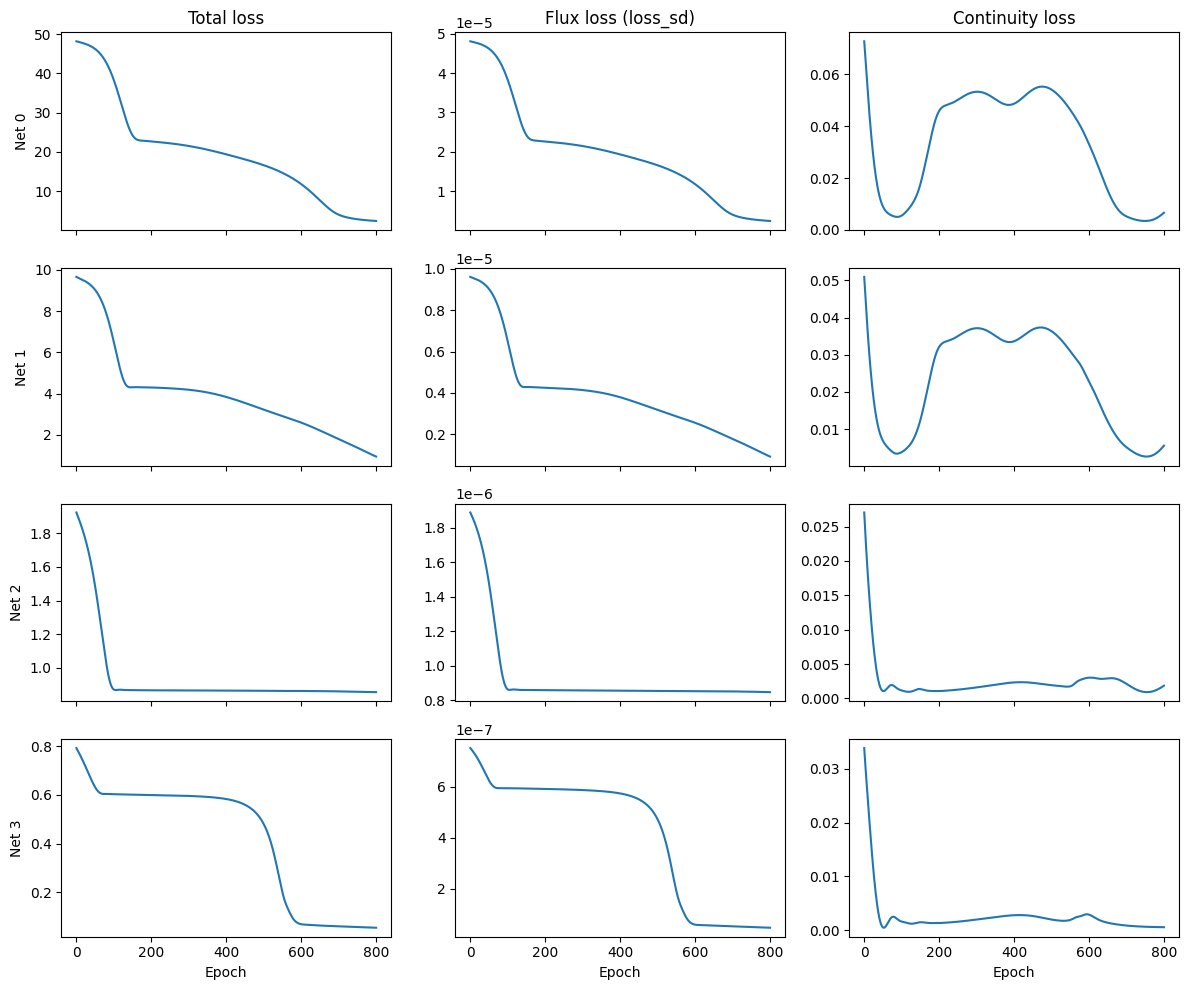

In [6]:
import matplotlib.pyplot as plt

# loss_sd_arr[k], loss_cont_arr[k], loss_total_arr[k] are lists over epochs for net k

num_nets = 4
fig, axes = plt.subplots(num_nets, 3, figsize=(12, 10), sharex=True)
# If num_nets == 1, axes won't be 2D, so we could guard against that; but here it's 4.

for k in range(num_nets):
    epochs_total = range(len(loss_total_arr[k]))
    epochs_sd    = range(len(loss_sd_arr[k]))
    epochs_cont  = range(len(loss_cont_arr[k]))

    # Column 0: total loss
    ax0 = axes[k, 0]
    ax0.plot(epochs_total, loss_total_arr[k])
    ax0.set_ylabel(f"Net {k}")
    if k == 0:
        ax0.set_title("Total loss")

    # Column 1: flux loss
    ax1 = axes[k, 1]
    ax1.plot(epochs_sd, loss_sd_arr[k])
    if k == 0:
        ax1.set_title("Flux loss (loss_sd)")

    # Column 2: continuity loss
    ax2 = axes[k, 2]
    ax2.plot(epochs_cont, loss_cont_arr[k])
    if k == 0:
        ax2.set_title("Continuity loss")

# Common x-label
for ax in axes[-1, :]:
    ax.set_xlabel("Epoch")

plt.tight_layout()
plt.show()

In [7]:
LCE_CG = []
LCE_rec = []
indices = []

LCE_CG_int = []
LCE_rec_int = []
indices_int = []
for local_cell_idx, cell_verts in enumerate(tqdm(local_cell_vertices)):
    # cell_verts are global vertex indices
    coords = omega_geometry[cell_verts]  # shape (3,2)
    sd = cell_to_subdomain(local_cell_idx)
    net = nets[sd]
    centroid = np.mean(coords, axis=0).reshape(1,-1)

    loc_cells = np.array([[0, 1, 2]], dtype=np.int64)

    gdim = coords.shape[1]
    coord_el = basix.ufl.element("Lagrange", "triangle", 1, shape=(gdim,))

    local_mesh = dmesh.create_mesh(
        MPI.COMM_SELF,
        loc_cells,
        coord_el,   # <-- this is the required "e" argument
        coords
    )
    cell_dofs = V.dofmap.cell_dofs(local_cell_idx)
    # -------------------------------------------------
    # 2. Local vector CG2 space for r_θ
    # -------------------------------------------------
    # Vector-valued CG2 (shape=(gdim,))
    V_loc = fem.functionspace(local_mesh, ("CG", order+1, (gdim,)))
    r_loc = fem.Function(V_loc)

    # -------------------------------------------------
    # 3. Interpolate NN into r_loc via dof coordinates
    # -------------------------------------------------
    x_loc = V_loc.tabulate_dof_coordinates()[:,0:2]  # (Ndofs, gdim)
    x_loc_torch = torch.tensor(x_loc, dtype=torch.float32)      # NN input

    r_vals_torch = net(x_loc_torch)                             # (Ndofs, gdim)
    r_vals = r_vals_torch.detach().cpu().numpy().reshape(-1)

    # assign to local FEM function
    r_loc.x.array[:] = r_vals.astype(default_scalar_type)

    # -------------------------------------------------
    # 4. Compute ∫_{∂D_j} r_θ · n ds on local mesh
    # -------------------------------------------------
    n_K = ufl.FacetNormal(local_mesh)
    int_r_form = fem.form(ufl.dot(r_loc, n_K) * ufl.ds)
    int_r_local = fem.assemble_scalar(int_r_form)

    # -------------------------------------------------
    # 5. Combine with q_cg and f (precomputed per cell)
    # -------------------------------------------------
    P_loc = fem.functionspace(local_mesh, ("CG", order))
    p_K = fem.Function(P_loc)

    # DOFs on this cell in the global space
    global_dofs = V.dofmap.cell_dofs(local_cell_idx)

    # DOFs on the (only) cell in the local space
    local_dofs = P_loc.dofmap.cell_dofs(0)

    p_K.x.array[local_dofs] = p_sol.x.array[global_dofs]
    p_K.x.scatter_forward()

    k_m_loc = fem.Function(P_loc)
    k_m_loc.x.array[local_dofs] = k_m.x.array[global_dofs]

    q_CG = -k_m_loc * ufl.grad(p_K)
    int_qcg = fem.assemble_scalar(
                fem.form(ufl.dot(q_CG, n_K) * ufl.ds(domain=local_mesh))
            )   # ∫_{∂D_j} q_cg · n
    
    f_m_loc = fem.Function(P_loc)
    f_m_loc.x.array[local_dofs] = f.x.array[global_dofs]
    f_m_loc.x.scatter_forward()
    int_f   = fem.assemble_scalar(fem.form(f_m_loc * ufl.dx(domain=local_mesh)))       # ∫_{D_j} f

    residual_j = int_r_local + int_qcg - int_f

    LCE_CG.append(int_qcg - int_f)
    LCE_rec.append(residual_j)
    indices.append(local_cell_idx)

    left_dofs_P = fem.locate_dofs_geometrical(
        P_loc, lambda x: np.isclose(x[0], xmin, atol=tol)
    )
    right_dofs_P = fem.locate_dofs_geometrical(
        P_loc, lambda x: np.isclose(x[0], xmax, atol=tol)
    )

    if (len(left_dofs_P) == 0) and (len(right_dofs_P) == 0):
        LCE_CG_int.append(int_qcg - int_f)
        LCE_rec_int.append(residual_j)
        indices_int.append(local_cell_idx)

100%|██████████| 512/512 [00:03<00:00, 167.13it/s]


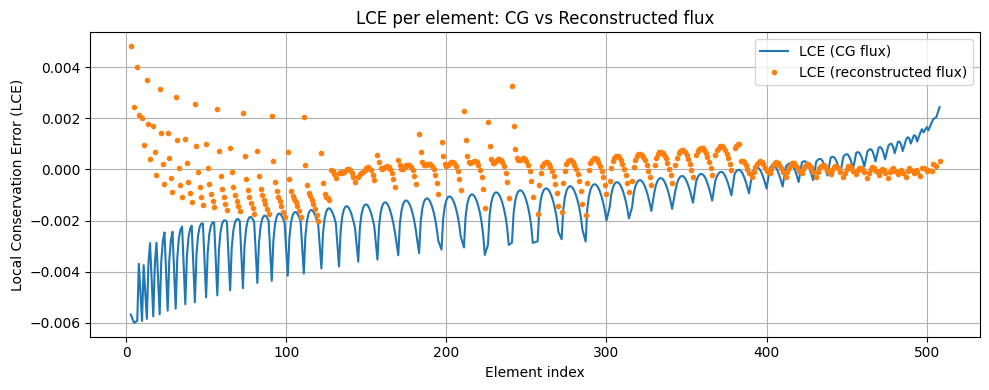

CG LCE stats: {'min': -0.006003117505676121, 'max': 0.002438592789572943, 'L1_mean_abs': 0.001492693584011395, 'L2_rms': 0.0019014356027301429}
Reconstructed LCE stats: {'min': -0.0020206814854273622, 'max': 0.004819523631750296, 'L1_mean_abs': 0.0005450296656235127, 'L2_rms': 0.0008323936997948284}


In [8]:

indices_plot = np.array(indices_int, dtype=int)
LCE_CG_plot = np.array(LCE_CG_int, dtype=float)
LCE_rec_plot = np.array(LCE_rec_int, dtype=float)

# plot
plt.figure(figsize=(10,4))
plt.plot(indices_plot, LCE_CG_plot, label="LCE (CG flux)")
plt.plot(indices_plot, LCE_rec_plot, ".", label="LCE (reconstructed flux)")
plt.xlabel("Element index")
plt.ylabel("Local Conservation Error (LCE)")
plt.title("LCE per element: CG vs Reconstructed flux")
plt.legend()
plt.grid(True)
plt.tight_layout()
# out_path = "/mnt/data/lce_plot.png"
# plt.savefig(out_path)
plt.show()

# print stats & produce dataframe
def stats(arr):
    return {"min": float(arr.min()), "max": float(arr.max()), "L1_mean_abs": float(np.mean(np.abs(arr))), "L2_rms": float(np.sqrt(np.mean(arr**2)))}
print("CG LCE stats:", stats(LCE_CG_plot))
print("Reconstructed LCE stats:", stats(LCE_rec_plot))

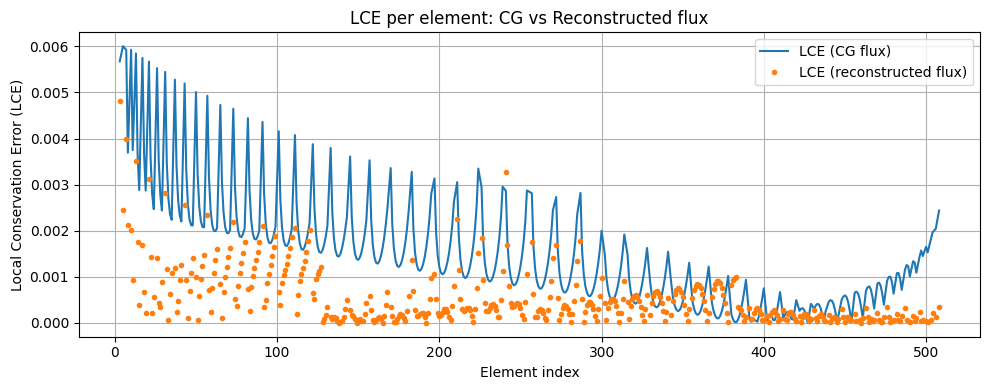

CG LCE stats: {'min': -0.006003117505676121, 'max': 0.002438592789572943, 'L1_mean_abs': 0.001492693584011395, 'L2_rms': 0.0019014356027301429}
Reconstructed LCE stats: {'min': -0.0020206814854273622, 'max': 0.004819523631750296, 'L1_mean_abs': 0.0005450296656235127, 'L2_rms': 0.0008323936997948284}


In [9]:
import matplotlib.pyplot as plt
indices_plot = np.array(indices_int, dtype=int)
LCE_CG_plot = np.array(LCE_CG_int, dtype=float)
LCE_rec_plot = np.array(LCE_rec_int, dtype=float)

# plot
plt.figure(figsize=(10,4))
plt.plot(indices_plot, np.abs(LCE_CG_plot), label="LCE (CG flux)")
plt.plot(indices_plot, np.abs(LCE_rec_plot), ".", label="LCE (reconstructed flux)")
plt.xlabel("Element index")
plt.ylabel("Local Conservation Error (LCE)")
plt.title("LCE per element: CG vs Reconstructed flux")
plt.legend()
plt.grid(True)
plt.tight_layout()
# out_path = "/mnt/data/lce_plot.png"
# plt.savefig(out_path)
plt.show()

# print stats & produce dataframe
def stats(arr):
    return {"min": float(arr.min()), "max": float(arr.max()), "L1_mean_abs": float(np.mean(np.abs(arr))), "L2_rms": float(np.sqrt(np.mean(arr**2)))}
print("CG LCE stats:", stats(LCE_CG_plot))
print("Reconstructed LCE stats:", stats(LCE_rec_plot))